In [1]:
from nldg.utils import *
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
import copy
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error
from itertools import product
from scipy.stats import dirichlet
from collections import defaultdict

NAME_RF = "MaxRM-RF"

## Comparison with Magging

In [2]:
demean_setting = 2
dtr = gen_data_v3(n=1000, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
random_state = 42
min_samples_leaf = 15

if demean_setting == 1:
    Ytr = Ytr_orig
elif demean_setting == 2:  # center the data in each environment
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])

In [3]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
min_reward(Ytr, fitted_rf, Etr, verbose=True)

Environment 0 reward: 8.434015991779598
Environment 1 reward: 2.0186800303153625
Environment 2 reward: 3.5926215139898305


np.float64(2.0186800303153625)

In [4]:
rf.modify_predictions_trees(Etr, method="reward", verbose=True)
fitted_rw = rf.predict(Xtr)
preds_rw = rf.predict(Xtr_sorted)
min_reward(Ytr, fitted_rw, Etr, verbose=True)

Initial score: -2.018680
Optimized score: -3.054010
Environment 0 reward: 6.53204706728571
Environment 1 reward: 3.5329890253349667
Environment 2 reward: 3.054009654234518


np.float64(3.054009654234518)

In [5]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging = rf_magging.fit(Xtr, Ytr, Etr)
preds_magging = rf_magging.predict(Xtr_sorted)
wmag = rf_magging.get_weights()

min_reward(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 reward: 3.723962590666975
Environment 1 reward: -26.131661941523568
Environment 2 reward: -0.9843995103232004


np.float64(-26.131661941523568)

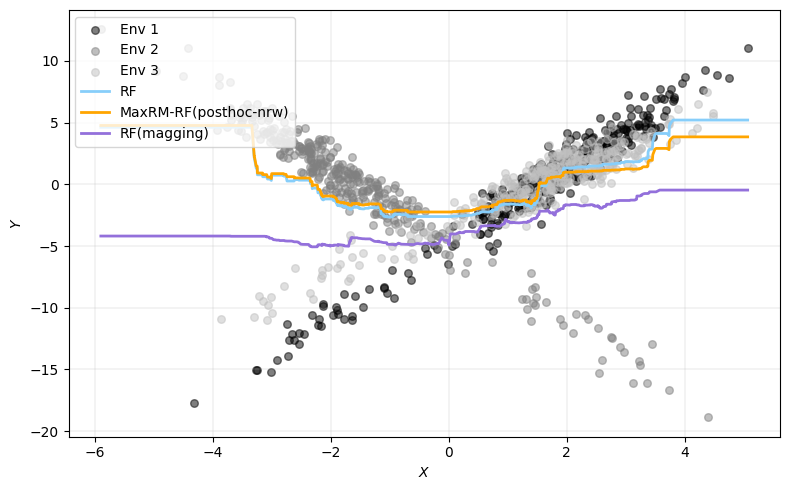

In [6]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_minmax"] = preds_rw
dtr["fitted_magging"] = preds_magging
dtr["Y"] = Ytr

plot_dtr(dtr, saveplot=True, nameplot="setting2_magging_comparison", suffix="posthoc-nrw")

## Extragradient Method: Different Objectives

In [7]:
demean_setting = 1
dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2)

Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
random_state = 42
min_samples_leaf = 30

dte = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2, random_state=42)
Xte = np.array(dte.drop(columns=["E", "Y"]))
Yte_orig = np.array(dte['Y'])
Ete = np.array(dte["E"])

if demean_setting == 1:
    Ytr = Ytr_orig
    Yte = Yte_orig
elif demean_setting == 2:
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])
    Yte = np.zeros_like(Yte_orig)
    for env in np.unique(Ete):
        idx = Ete == env
        Yte[idx] = Yte_orig[idx] - np.mean(Yte_orig[idx])

# Fit standard RF for each environment separately.
# This is used for the regret
sols_erm = np.zeros(Etr.shape[0])
sols_erm_te = np.zeros(Ete.shape[0])
sols_erm_trees = np.zeros((n_estimators, Etr.shape[0]))
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree
    mask_e_te = Ete == env
    fitted_e_te = rf_e.predict(Xte[mask_e_te])
    sols_erm_te[mask_e_te] = fitted_e_te

In [8]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xte)
preds_rf = rf.predict(Xtr_sorted)

mse_rf, _ = max_mse(Yte, fitted_rf, Ete, ret_ind=True)
rw_rf, _ = min_reward(Yte, fitted_rf, Ete, ret_ind=True)
regret_rf, _ = max_regret(Yte, fitted_rf, sols_erm_te, Ete, ret_ind=True)

In [9]:
rf.modify_predictions_trees(Etr, opt_method="extragradient")  # can try verbose=True
fitted_mse = rf.predict(Xte)
preds_mse = rf.predict(Xtr_sorted)

mse_mse, _ = max_mse(Yte, fitted_mse, Ete, ret_ind=True)
rw_mse, _ = min_reward(Yte, fitted_mse, Ete, ret_ind=True)
regret_mse, _ = max_regret(Yte, fitted_mse, sols_erm_te, Ete, ret_ind=True)

In [10]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr, method="reward",
                            opt_method="extragradient")
fitted_rw = rf.predict(Xte)
preds_rw = rf.predict(Xtr_sorted)

mse_rw, _ = max_mse(Yte, fitted_rw, Ete, ret_ind=True)
rw_rw, _ = min_reward(Yte, fitted_rw, Ete, ret_ind=True)
regret_rw, _ = max_regret(Yte, fitted_rw, sols_erm_te, Ete, ret_ind=True)

In [11]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(
    Etr,
    method="regret",
    sols_erm=sols_erm,
    sols_erm_trees=sols_erm_trees,
    opt_method="extragradient",
    # verbose=True,
)
fitted_regret = rf.predict(Xte)
preds_regret = rf.predict(Xtr_sorted)

mse_regret, _ = max_mse(Yte, fitted_regret, Ete, ret_ind=True)
rw_regret, _ = min_reward(Yte, fitted_regret, Ete, ret_ind=True)
regret_regret, _ = max_regret(Yte, fitted_regret, sols_erm_te, Ete, ret_ind=True)

In [12]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
_ = rf_magging.fit(Xtr, Ytr, Etr)
wmag = rf_magging.get_weights()
fitted_magging = rf_magging.predict(Xte)
preds_magging = rf_magging.predict(Xtr_sorted)

mse_magging, _ = max_mse(Yte, fitted_magging, Ete, ret_ind=True)
rw_magging, _ = min_reward(Yte, fitted_magging, Ete, ret_ind=True)
regret_magging, _ = max_regret(Yte, fitted_magging, sols_erm_te, Ete, ret_ind=True)

In [13]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Reward", "Regret"], ["0", "1"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_rf + rw_rf + regret_rf],
    [round(float(x), 3) for x in mse_mse + rw_mse + regret_mse],
    [round(float(x), 3) for x in mse_rw + rw_rw + regret_rw],
    [round(float(x), 3) for x in mse_regret + rw_regret + regret_regret],
    [round(float(x), 3) for x in mse_magging + rw_magging + regret_magging],
]
df = pd.DataFrame(
    data,
    index=
    [
        "RF",
        f"{NAME_RF}(posthoc-mse)",
        f"{NAME_RF}(posthoc-nrw)",
        f"{NAME_RF}(posthoc-reg)",
        "RF(magging)"
    ],
    columns=cols)
print(df)

Metric                   MSE         Reward         Regret        
Env                        0       1      0       1      0       1
RF                     0.419  15.434  1.116  12.344  0.153  11.965
MaxRM-RF(posthoc-mse)  5.908   5.522 -4.373  22.257  5.642   2.053
MaxRM-RF(posthoc-nrw)  0.268  18.282  1.267   9.497  0.002  14.813
MaxRM-RF(posthoc-reg)  3.531   7.576 -1.996  20.203  3.265   4.106
RF(magging)            0.266  18.166  1.269   9.613  0.000  14.696


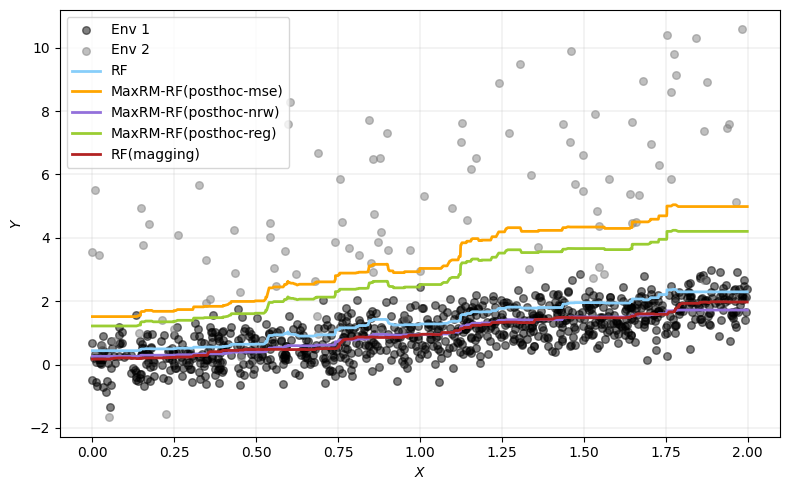

In [14]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_mse"] = preds_mse
dtr["fitted_nrw"] = preds_rw
dtr["fitted_regret"] = preds_regret
dtr["fitted_magging"] = preds_magging
dtr["Y"] = Ytr

plot_dtr(dtr, obj_comparison=True)

## Generalization Gap

In [15]:
# We don't use a test set: this is just for demonstration
d = 1
E = 3
n_train_per_env = [1000, 500, 500]
n_test = 500
sigma_eps  = 0.1
kernel = ConstantKernel(1.0) * RBF(length_scale=0.5)
SEED = 42
rng = np.random.default_rng(SEED)

def sample_gp_function(x_grid):
    K = kernel(x_grid, x_grid)
    f_vals = rng.multivariate_normal(np.zeros(len(x_grid)), K)
    return lambda x: np.interp(x.ravel(), x_grid.ravel(), f_vals)

x_grid = np.linspace(-1, 1, 1000).reshape(-1, 1)
f_env  = [sample_gp_function(x_grid) for _ in range(E)]

def make_dataset(f, env_id, n_samples):
    X = rng.uniform(-1, 1, size=(n_samples, d))
    eps = rng.normal(0, sigma_eps, size=n_samples)
    y_noise = f(X) + eps
    env_lab = np.full(n_samples, env_id)
    # y_noise = y_noise - np.mean(y_noise)
    return X, y_noise, env_lab

train_sets = [
    make_dataset(f_env[e], env_id=e, n_samples=n_train_per_env[e])
    for e in range(E)
]

X_tr = np.vstack([ts[0] for ts in train_sets])
y_tr = np.hstack([ts[1] for ts in train_sets])
env_label = np.hstack([ts[2] for ts in train_sets])

w = dirichlet.rvs(alpha=np.ones(E), random_state=rng).ravel()
f_test = lambda x: sum(w[e] * f_env[e](x) for e in range(E))
X_te = rng.uniform(-1, 1, size=(n_test, d))
eps_te = rng.normal(0, sigma_eps, size=n_test)
y_te_clean = f_test(X_te)
y_te = y_te_clean + eps_te
# y_te = y_te - np.mean(y_te)

In [16]:
n_estimators = 50
random_state = 42
min_samples_leaf = 20
X_tr_sorted = np.sort(X_tr, axis=0)

sols_erm = np.zeros(env_label.shape[0])
sols_erm_trees = np.zeros((n_estimators, env_label.shape[0]))
for env in np.unique(env_label):
    mask = env_label == env
    X_e = X_tr[mask]
    Y_e = y_tr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree

rf_mse = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf_mse.fit(X_tr, y_tr)
fitted_tr_rf = rf_mse.predict(X_tr)
preds_tr_rf = rf_mse.predict(X_tr_sorted)
mse_rf, _ = max_mse(y_tr, fitted_tr_rf, env_label, ret_ind=True)
rw_rf, _ = min_reward(y_tr, fitted_tr_rf, env_label, ret_ind=True)
regret_rf, _ = max_regret(y_tr, fitted_tr_rf, sols_erm, env_label, ret_ind=True)

In [17]:
rf_mse.modify_predictions_trees(env_label)
fitted_tr_mse = rf_mse.predict(X_tr)
preds_tr_mse = rf_mse.predict(X_tr_sorted)

mse_mse, _ = max_mse(y_tr, fitted_tr_mse, env_label, ret_ind=True)
rw_mse, _ = min_reward(y_tr, fitted_tr_mse, env_label, ret_ind=True)
regret_mse, _ = max_regret(y_tr, fitted_tr_mse, sols_erm, env_label, ret_ind=True)

In [18]:
rf_rw = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf_rw.fit(X_tr, y_tr)
rf_rw.modify_predictions_trees(env_label, method="reward")
fitted_tr_rw = rf_rw.predict(X_tr)
preds_tr_rw = rf_rw.predict(X_tr_sorted)

mse_rw, _ = max_mse(y_tr, fitted_tr_rw, env_label, ret_ind=True)
rw_rw, _ = min_reward(y_tr, fitted_tr_rw, env_label, ret_ind=True)
regret_rw, _ = max_regret(y_tr, fitted_tr_rw, sols_erm, env_label, ret_ind=True)

In [19]:
rf_regret = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf_regret.fit(X_tr, y_tr)
rf_regret.modify_predictions_trees(
    env_label,
    method="regret",
    sols_erm=sols_erm,
    sols_erm_trees=sols_erm_trees
)
fitted_tr_regret = rf_regret.predict(X_tr)
preds_tr_regret = rf_regret.predict(X_tr_sorted)

mse_regret, _ = max_mse(y_tr, fitted_tr_regret, env_label, ret_ind=True)
rw_regret, _ = min_reward(y_tr, fitted_tr_regret, env_label, ret_ind=True)
regret_regret, _ = max_regret(y_tr, fitted_tr_regret, sols_erm, env_label, ret_ind=True)

In [20]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Reward", "Regret"], ["0", "1", "2"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_rf + rw_rf + regret_rf],
    [round(float(x), 3) for x in mse_mse + rw_mse + regret_mse],
    [round(float(x), 3) for x in mse_rw + rw_rw + regret_rw],
    [round(float(x), 3) for x in mse_regret + rw_regret + regret_regret],
]
df = pd.DataFrame(
    data,
    index=
    [
        "RF",
        f"{NAME_RF}(posthoc-mse)",
        f"{NAME_RF}(posthoc-nrw)",
        f"{NAME_RF}(posthoc-reg)",
    ],
    columns=cols)
print(df)

Metric                   MSE               Reward               Regret         \
Env                        0      1      2      0      1      2      0      1   
RF                     0.080  0.107  0.140  0.439  0.110  0.161  0.071  0.096   
MaxRM-RF(posthoc-mse)  0.102  0.102  0.108  0.417  0.115  0.193  0.093  0.092   
MaxRM-RF(posthoc-nrw)  0.294  0.022  0.109  0.225  0.195  0.192  0.285  0.012   
MaxRM-RF(posthoc-reg)  0.101  0.102  0.109  0.418  0.115  0.192  0.092  0.092   

Metric                        
Env                        2  
RF                     0.130  
MaxRM-RF(posthoc-mse)  0.098  
MaxRM-RF(posthoc-nrw)  0.099  
MaxRM-RF(posthoc-reg)  0.099  


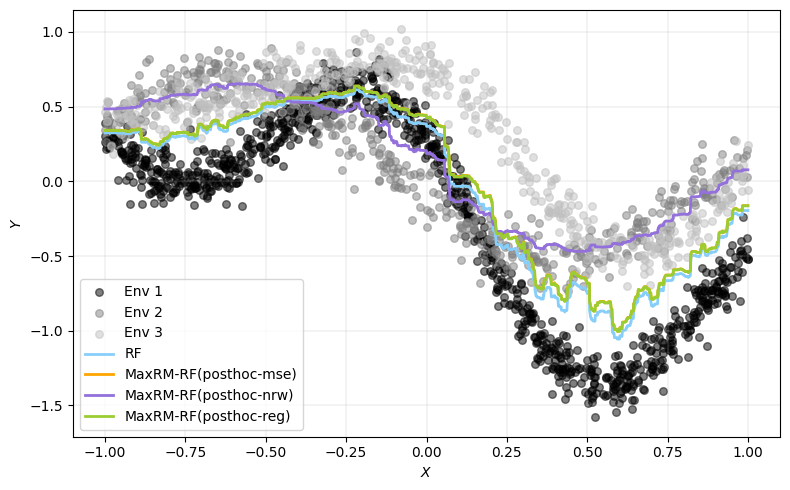

In [21]:
dtr = pd.DataFrame({
    "X": X_tr.ravel(),
    "Y": y_tr.ravel(),
    "E": env_label.ravel(),
    "X_sorted": X_tr_sorted.ravel(),
    "fitted_rf": preds_tr_rf.ravel(),
    "fitted_mse": preds_tr_mse.ravel(),
    "fitted_nrw": preds_tr_rw.ravel(),
    "fitted_regret": preds_tr_regret.ravel(),
})

plot_dtr(dtr, obj_comparison=True, legend_pos=None)

In [22]:
fitted_te_mse = rf_mse.predict(X_te)
fitted_te_rw = rf_rw.predict(X_te)
fitted_te_regret = rf_regret.predict(X_te)
# Compute metric for each training environment using f_env[e] on test inputs
mse_per_env, rw_per_env, regret_per_env = [], [], []
for e in range(E):
    y_env = f_env[e](X_te) + eps_te

    mse = mean_squared_error(y_env, fitted_te_mse)
    mse_per_env.append(mse)

    rw = mean_squared_error(y_env, fitted_te_rw) - np.mean(y_env ** 2)
    rw_per_env.append(rw)

    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state,
    )
    rf_e.fit(X_te, y_env)
    sols_erm_e = rf_e.predict(X_te)
    regret = mean_squared_error(y_env, fitted_te_regret) - mean_squared_error(y_env, sols_erm_e)
    regret_per_env.append(regret)

max_mse_train = max(mse_per_env)
max_rw_train = max(rw_per_env)
max_regret_train = max(regret_per_env)

In [23]:
grid_size = 15
q1_vals = np.linspace(0, 1, grid_size)
q2_vals = np.linspace(0, 1, grid_size)
results_mse, results_rw, results_regret = [], [], []
mse_diff_map, rw_diff_map, regret_diff_map = (
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
)

for q1, q2 in product(q1_vals, q2_vals):
    if q1 + q2 > 1:
        continue
    q3 = 1 - q1 - q2
    q = [q1, q2, q3]
    f_test = lambda x: sum(q[e] * f_env[e](x) for e in range(E))
    y_te = f_test(X_te) + eps_te

    mse = mean_squared_error(y_te, fitted_te_mse)
    results_mse.append((q1, q2, mse - max_mse_train))
    mse_diff_map[(q1, q2)].append(mse - max_mse_train)

    rw = mean_squared_error(y_te, fitted_te_rw) - np.mean(y_te ** 2)
    results_rw.append((q1, q2, rw - max_rw_train))
    rw_diff_map[(q1, q2)].append(rw - max_rw_train)

    rf_te = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state,
    )
    rf_te.fit(X_te, y_te)
    sols_erm_te = rf_te.predict(X_te)
    regret = mean_squared_error(y_te, fitted_te_regret) - mean_squared_error(y_te, sols_erm_te)
    results_rw.append((q1, q2, regret - max_regret_train))
    regret_diff_map[(q1, q2)].append(regret - max_regret_train)

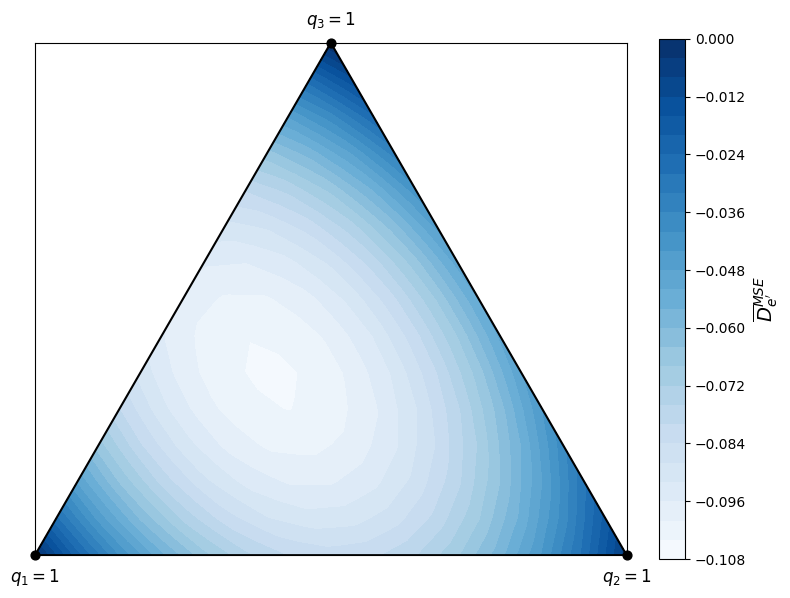

In [28]:
plot_tricontour(mse_diff_map, "mse")

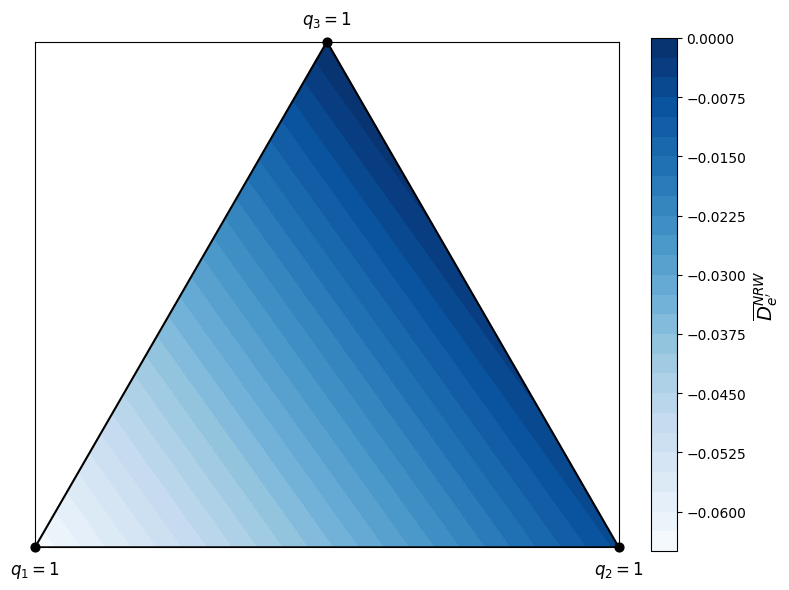

In [29]:
plot_tricontour(rw_diff_map, "negrew")

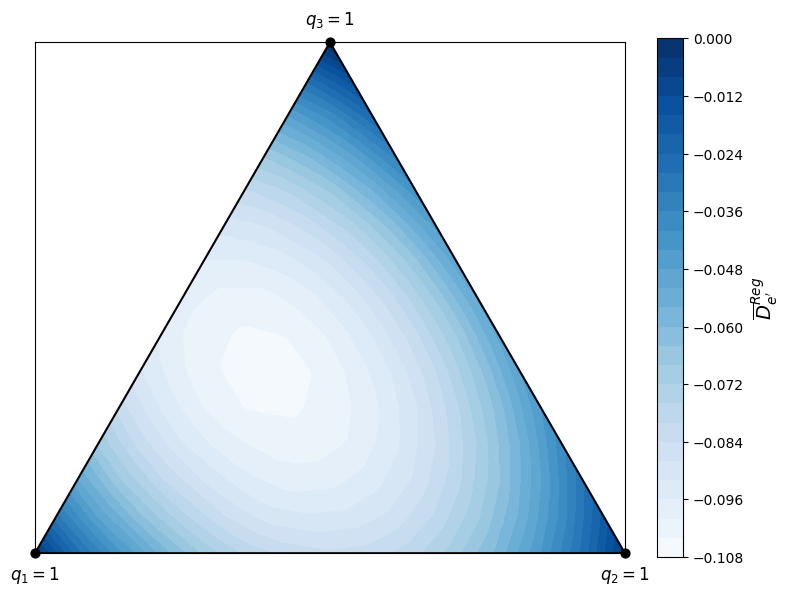

In [30]:
plot_tricontour(regret_diff_map, "regret")

## When is the MSE not the right metric to use?

In [31]:
d = 1
E = 3
n = 1500
kernel = ConstantKernel(1.0) * RBF(length_scale=0.5)
SEED = 0
rng = np.random.default_rng(SEED)

X = rng.uniform(-1, 1, size=(n, d))


def sample_gp_function(x_grid):
    K = kernel(x_grid, x_grid)
    f_vals = rng.multivariate_normal(np.zeros(len(x_grid)), K)
    return lambda x: np.interp(x.ravel(), x_grid.ravel(), f_vals)

x_grid = np.linspace(-1, 1, 1000).reshape(-1, 1)
f_env  = [sample_gp_function(x_grid) for _ in range(E)]

def make_dataset(f, env_id, n_samples):
    y_clean  = f(X)
    env_lab  = np.full(n_samples, env_id)
    return X, y_clean, env_lab

train_sets = [
    make_dataset(f_env[e], env_id=e, n_samples=n)
    for e in range(E)
]

X_tr = np.vstack([ts[0] for ts in train_sets])
y_tr_clean = np.hstack([ts[1] for ts in train_sets])
env_label = np.hstack([ts[2] for ts in train_sets])

In [32]:
# Let the third environment be the noisiest one
# Compute, for each environment e != 2, E[(f^e(X)-f^{2}(X))^2]
k = 2
mask_k = env_label == k
max_delta = 0
for e in range(E):
    if e != k:
        mask = env_label == e
        delta = np.mean((y_tr_clean[mask] - y_tr_clean[mask_k]) ** 2)
        print(delta)
        max_delta = max(max_delta, delta)

0.8773040775738697
1.5267993830959483


In [33]:
# Therefore, if sigma = sigma_0 = sigma_1 = 0.1,
# we need to choose sigma_2^2 >= max_delta + sigma^2
y_tr = copy.deepcopy(y_tr_clean)
sigma = 0.1
sigma_max = np.sqrt(max_delta + sigma**2)
eps = rng.normal(0, sigma, size=n)
eps_max = rng.normal(0, sigma_max, size=n)
for e in range(E):
    mask = env_label == e
    if e != k:
        y_tr[mask] += eps
    else:
        y_tr[mask] += eps_max

In [34]:
n_estimators = 50
random_state = 42
min_samples_leaf = 60  # 25
X_tr_sorted = np.sort(X_tr, axis=0)

rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(X_tr, y_tr)
fitted_rf = rf.predict(X_tr)
preds_rf = rf.predict(X_tr_sorted)
max_mse(y_tr, fitted_rf, env_label, verbose=True)

Environment 0 MSE: 0.14898660846303308
Environment 1 MSE: 0.3861908883120905
Environment 2 MSE: 2.058868987833605


np.float64(2.058868987833605)

In [35]:
rf.modify_predictions_trees(env_label, verbose=True)
fitted_minmax = rf.predict(X_tr)
preds_minmax = rf.predict(X_tr_sorted)
max_mse_train = max_mse(y_tr, fitted_minmax, env_label)
max_mse(y_tr, fitted_minmax, env_label, verbose=True)

Initial score: 2.058869
Optimized score: 1.621801
Environment 0 MSE: 0.6453508769523549
Environment 1 MSE: 1.220649798407258
Environment 2 MSE: 1.6218014716437108


np.float64(1.6218014716437108)

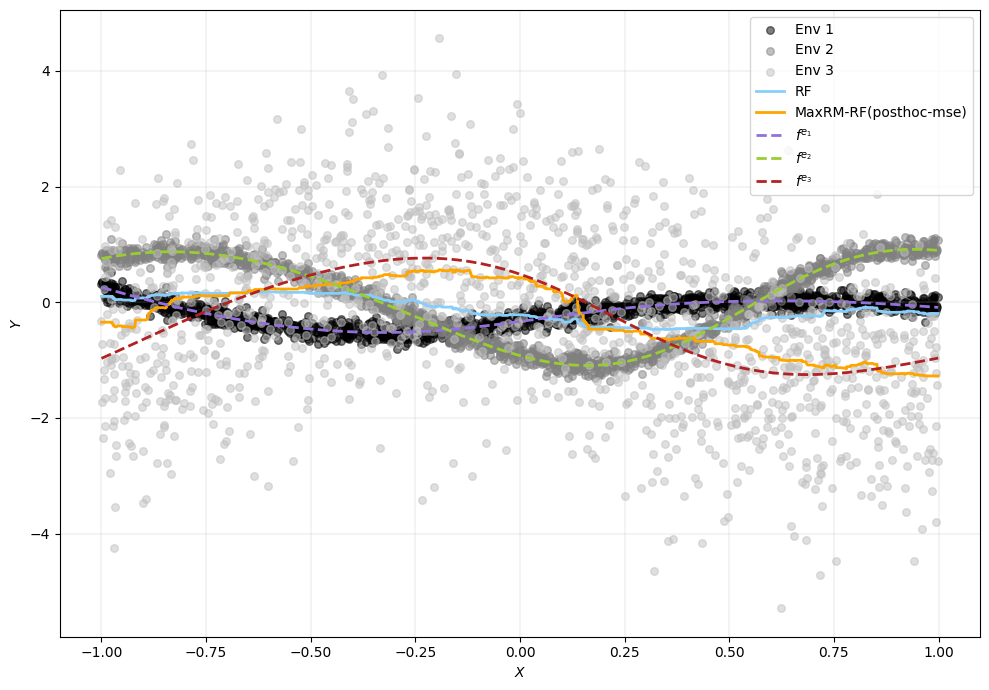

In [36]:
dtr = pd.DataFrame({
    "X": X_tr.ravel(),
    "Y": y_tr.ravel(),
    "E": env_label.ravel(),
    "X_sorted": X_tr_sorted.ravel(),
    "fitted_rf": preds_rf.ravel(),
    "fitted_minmax": preds_minmax.ravel(),
    "y_clean": y_tr_clean,
})

plot_dtr(dtr, suffix="posthoc-mse", legend_pos=None, saveplot=True, nameplot="mse_noisy_env")

In [37]:
import copy

n_estimators = 50
random_state = 42
min_samples_leaf = 60  # 25
X_tr_sorted = np.sort(X_tr, axis=0)

sols_erm = np.zeros(env_label.shape[0])
sols_erm_trees = np.zeros((n_estimators, env_label.shape[0]))
for env in np.unique(env_label):
    mask = env_label == env
    X_e = X_tr[mask]
    Y_e = y_tr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree

rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(X_tr, y_tr)
fitted_rf = rf.predict(X_tr)
preds_rf = rf.predict(X_tr_sorted)
max_mse(y_tr, fitted_rf, env_label, verbose=True)

Environment 0 MSE: 0.14898660846303308
Environment 1 MSE: 0.3861908883120905
Environment 2 MSE: 2.058868987833605


np.float64(2.058868987833605)

In [38]:
rf_mse = copy.deepcopy(rf)
rf_mse.modify_predictions_trees(env_label, verbose=True)
fitted_minmax = rf_mse.predict(X_tr)
preds_minmax = rf_mse.predict(X_tr_sorted)
max_mse(y_tr, fitted_minmax, env_label, verbose=True)

Initial score: 2.058869
Optimized score: 1.621801
Environment 0 MSE: 0.6453508769523549
Environment 1 MSE: 1.220649798407258
Environment 2 MSE: 1.6218014716437108


np.float64(1.6218014716437108)

In [39]:
rf_nrw = copy.deepcopy(rf)
rf_nrw.modify_predictions_trees(env_label, method="reward", verbose=True)
fitted_minmax_nrw = rf_nrw.predict(X_tr)
preds_minmax_nrw = rf_nrw.predict(X_tr_sorted)
max_mse(y_tr, fitted_minmax_nrw, env_label, verbose=True)

Initial score: 0.059985
Optimized score: -0.029860
Environment 0 MSE: 0.0513713361321166
Environment 1 MSE: 0.48616276739614794
Environment 2 MSE: 2.1679395013242204


np.float64(2.1679395013242204)

In [40]:
rf_reg = copy.deepcopy(rf)
rf_reg.modify_predictions_trees(env_label, method="regret", sols_erm=sols_erm, sols_erm_trees=sols_erm_trees, verbose=True)
fitted_minmax_reg = rf_reg.predict(X_tr)
preds_minmax_reg = rf_reg.predict(X_tr_sorted)
max_mse(y_tr, fitted_minmax_reg, env_label, verbose=True)

Initial score: 0.500934
Optimized score: 0.431296
Environment 0 MSE: 0.2946034611049272
Environment 1 MSE: 0.3859819411234539
Environment 2 MSE: 1.9892309300985114


np.float64(1.9892309300985114)

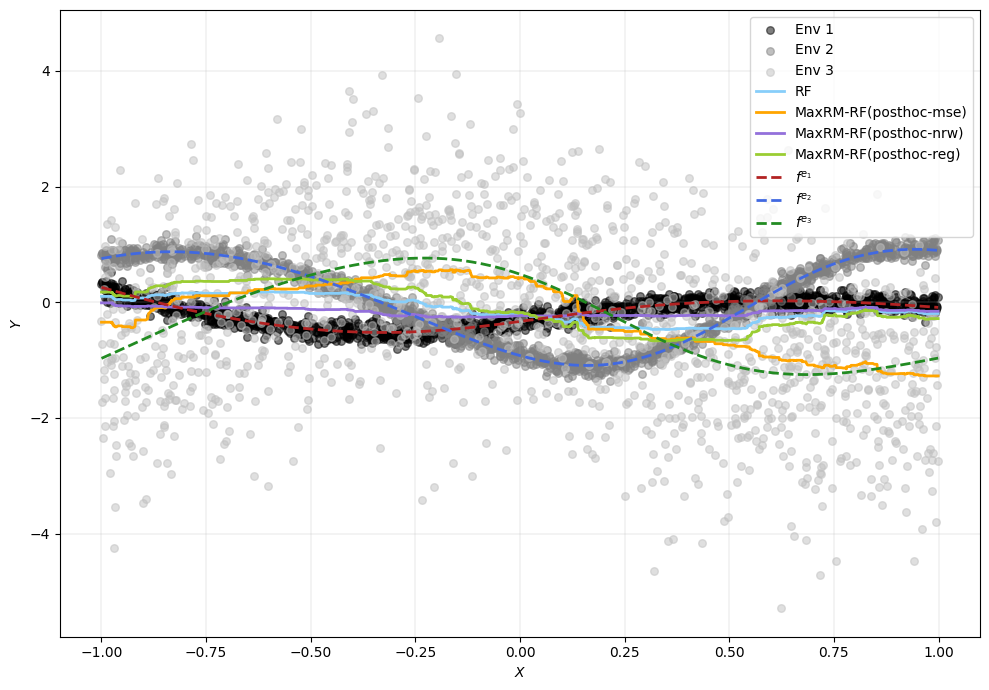

In [41]:
dtr = pd.DataFrame({
    "X": X_tr.ravel(),
    "Y": y_tr.ravel(),
    "E": env_label.ravel(),
    "X_sorted": X_tr_sorted.ravel(),
    "fitted_rf": preds_rf.ravel(),
    "fitted_mse": preds_minmax.ravel(),
    "fitted_nrw": preds_minmax_nrw.ravel(),
    "fitted_regret": preds_minmax_reg.ravel(),
    "y_clean": y_tr_clean,
})

plot_dtr(dtr, legend_pos="best", obj_comparison=True, saveplot=True, nameplot="mse_noisy_env_2")